In [2]:
import pandas as pd
from textblob import TextBlob

# Step 1: Load the CSV data into a pandas DataFrame
df = pd.read_csv(r"C:\Users\rajsi\OneDrive\Desktop\git_unsw\Bollywoodsongs-sentimentanalysis-\data\cleaned_file.csv")

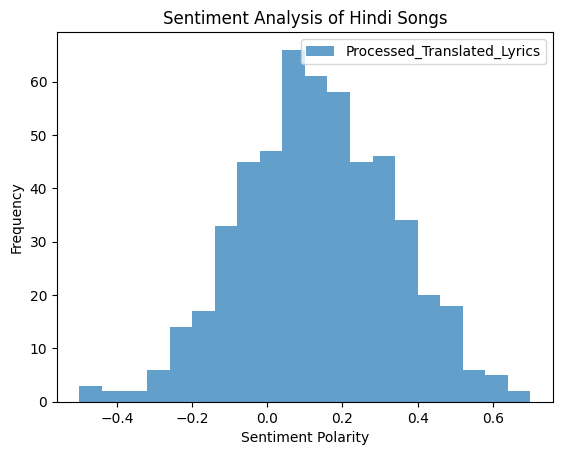

In [3]:
#using textblob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    # Return sentiment polarity (ranges from -1 to 1 where -1 is very negative and 1 is very positive)
    return analysis.sentiment.polarity

# Apply sentiment analysis to each row in 'Lyrics' and 'translated_Lyrics' columns
df['Processed_Translated_Lyrics_sentiment'] = df['Processed_Translated_Lyrics'].apply(analyze_sentiment)
# df['English_Sentiment'] = df['translated_Lyrics'].apply(analyze_sentiment)

# Step 4: Optionally, you can visualize the sentiment scores
import matplotlib.pyplot as plt

plt.hist(df['Processed_Translated_Lyrics_sentiment'], bins=20, alpha=0.7, label='Processed_Translated_Lyrics')
# plt.hist(df['English_Sentiment'], bins=20, alpha=0.7, label='English Sentiment')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis of Hindi Songs')
plt.legend()
plt.show()


In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create a SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()

# Define a function to get sentiment scores using VADER
def analyze_sentiment_vader(text):
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores['compound']  # Using compound score for overall sentiment

# Apply sentiment analysis to Hindi lyrics
df['English_Sentiment_VADER'] = df['translated_Lyrics'].apply(analyze_sentiment_vader)


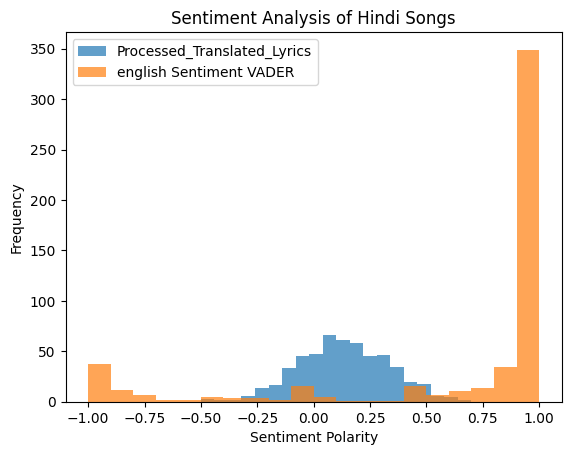

In [5]:
plt.hist(df['Processed_Translated_Lyrics_sentiment'], bins=20, alpha=0.7, label='Processed_Translated_Lyrics')
# plt.hist(df['English_Sentiment'], bins=20, alpha=0.7, label='English Sentiment')
plt.hist(df['English_Sentiment_VADER'], bins=20, alpha=0.7, label='english Sentiment VADER')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis of Hindi Songs')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

def convert_to_category(score):
    if score < 0:
        return 'negative'
    elif score > 0:
        return 'positive'
    else:
        return 'neutral'

# Apply conversion function to create categorical columns
df['TextBlob_Sentiment_Category'] = df['Processed_Translated_Lyrics_sentiment'].apply(convert_to_category)
df['VADER_Sentiment_Category'] = df['English_Sentiment_VADER'].apply(convert_to_category)

In [10]:
accuracy_vader = accuracy_score(df['TextBlob_Sentiment_Category'], df['VADER_Sentiment_Category'])
accuracy_vader

0.7528301886792453

In [27]:
from pattern.en import sentiment

# Function to compute sentiment using Pattern
def pattern_sentiment(text):
    return sentiment(text)[0]  # Returns the polarity

# Apply sentiment computation
df['pattern_polarity'] = df['Processed_Translated_Lyrics'].apply(pattern_sentiment)

# Categorize sentiment
df['pattern_sentiment'] = df['pattern_polarity'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

print(df)

     Unnamed: 0                           songs  \
0             0                         Ole Ole   
1             1         Yeh Raat Aur Yeh Doorie   
2             2  Aaja Meri Gaadi Mein Baith Jaa   
3             3              Meri Pant Bhi Sexy   
4             4                   Dil Mein Tere   
..          ...                             ...   
525         525                Bachpan Ka Pyaar   
526         526                     Paani Paani   
527         527                           Jugnu   
528         528              Bad Boy X Bad Girl   
529         529                          Voodoo   

                                 artist  year  \
0                              Abhijeet  1994   
1    Asha Bhosle, S.P. Balasubrahmanyam  1994   
2                Baba Sehgal, Anu Malik  1994   
3                  Govinda, Alka Yagnik  1994   
4          Jolly Mukherjee, Alka Yagnik  1994   
..                                  ...   ...   
525                             Badshah  202

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import torch

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Initialize sentiment analysis pipeline
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Function to compute sentiment using BERT
def bert_sentiment(text):
    # Tokenize input text, truncate and pad to max length
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    confidence, predicted_class = torch.max(probabilities, dim=1)
    sentiment_label = predicted_class.item()
    
    # Convert label to sentiment string
    if sentiment_label == 4:
        sentiment = 'positive'
    elif sentiment_label == 3:
        sentiment = 'neutral'
    elif sentiment_label == 2:
        sentiment = 'neutral'
    elif sentiment_label == 1:
        sentiment = 'negative'
    else:
        sentiment = 'negative'
    
    return sentiment, confidence.item()

# Apply sentiment computation
df[['bert_sentiment', 'bert_score']] = df['Processed_Translated_Lyrics'].apply(lambda x: pd.Series(bert_sentiment(x)))

print(df)


In [14]:
import pandas as pd
import seaborn as sns

# Count the number of each sentiment for both columns
textblob_counts = df['TextBlob_Sentiment_Category'].value_counts().reindex(['positive', 'negative', 'neutral'], fill_value=0)
vader_counts = df['VADER_Sentiment_Category'].value_counts().reindex(['positive', 'negative', 'neutral'], fill_value=0)


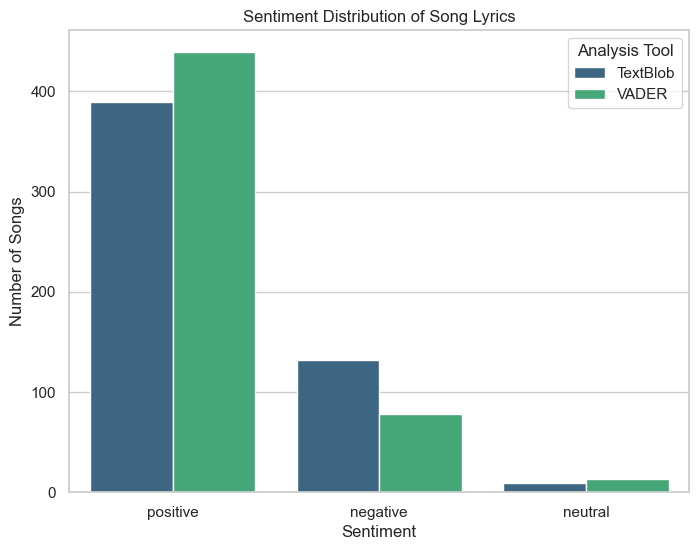

In [15]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Sentiment': ['positive', 'negative', 'neutral'] * 2,
    'Count': list(textblob_counts) + list(vader_counts),
    'Source': ['TextBlob'] * 3 + ['VADER'] * 3
})

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x='Sentiment', y='Count', hue='Source', data=plot_data, palette='viridis')

# Customize the plot
ax.set_title('Sentiment Distribution of Song Lyrics')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Songs')
plt.legend(title='Analysis Tool')
plt.show()


In [44]:
# Group by year and sentiment category
textblob_yearly_counts = df.groupby(['year', 'TextBlob_Sentiment_Category']).size().unstack(fill_value=0)
vader_yearly_counts = df.groupby(['year', 'VADER_Sentiment_Category']).size().unstack(fill_value=0)

# Ensure all sentiment categories are present
textblob_yearly_counts = textblob_yearly_counts.reindex(columns=['positive', 'negative', 'neutral'], fill_value=0)
vader_yearly_counts = vader_yearly_counts.reindex(columns=['positive', 'negative', 'neutral'], fill_value=0)


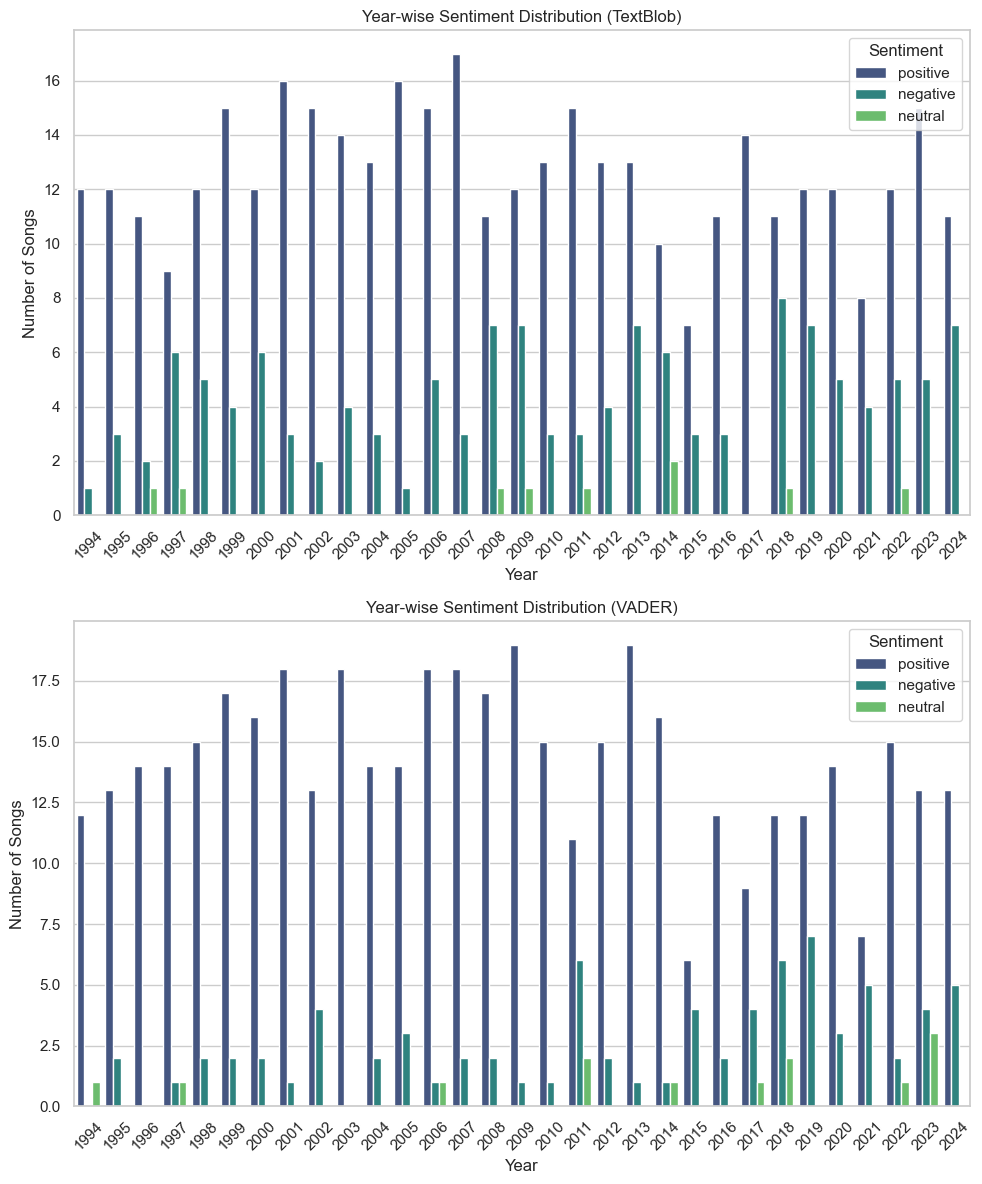

In [45]:
# Create a DataFrame for plotting
textblob_plot_data = textblob_yearly_counts.reset_index().melt(id_vars='year', var_name='Sentiment', value_name='Count')
vader_plot_data = vader_yearly_counts.reset_index().melt(id_vars='year', var_name='Sentiment', value_name='Count')

# Plot using seaborn with wider figure
plt.figure(figsize=(10, 12))

# Plot TextBlob Sentiment Distribution
plt.subplot(2, 1, 1)
sns.barplot(x='year', y='Count', hue='Sentiment', data=textblob_plot_data, palette='viridis')
plt.title('Year-wise Sentiment Distribution (TextBlob)')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.legend(title='Sentiment', loc='upper right')
plt.xticks(rotation=45)

# Plot VADER Sentiment Distribution
plt.subplot(2, 1, 2)
sns.barplot(x='year', y='Count', hue='Sentiment', data=vader_plot_data, palette='viridis')
plt.title('Year-wise Sentiment Distribution (VADER)')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.legend(title='Sentiment', loc='upper right')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


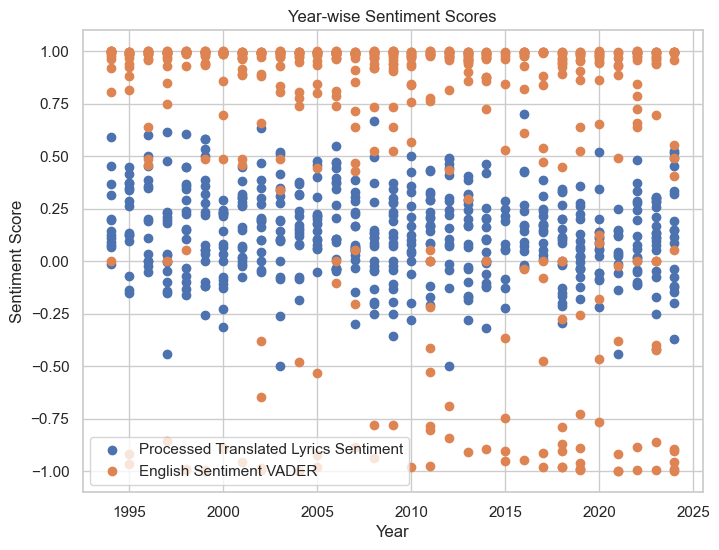

In [52]:

# Plotting scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['year'], df['Processed_Translated_Lyrics_sentiment'], label='Processed Translated Lyrics Sentiment', marker='o')
plt.scatter(df['year'], df['English_Sentiment_VADER'], label='English Sentiment VADER', marker='o')
plt.title('Year-wise Sentiment Scores')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()